In [31]:
import numpy as np
from numpy.linalg import inv, pinv, norm, cond
from matplotlib import pyplot as plt

In [32]:
def compute_SMW(n,k,A,B,U,V,lamda,e1,e2,alpha,rand_seed=1):
    # np.random.seed(rand_seed)    \
    # add noise
    noise1 = np.random.normal(size=(n,n))
    noise1 *= e1/norm(noise1,ord=2)
    noise2 = np.random.normal(size=(k,k))
    noise2 *= e2/norm(noise2,ord=2)

    A_inv = inv(A)
    A_inv_norm = norm(A_inv,ord=2)
    A_til_inv = A_inv + noise1
    Z_inv = inv(np.eye(k)+V.T@A_til_inv@U) + noise2
    B_inv_approx = A_til_inv - A_til_inv@U@Z_inv@V.T@A_til_inv
    B_inv = inv(B) 
    error = norm(B_inv-B_inv_approx,ord=2)
    bound =  2*e2*A_inv_norm + 12*e1
    # B_inv_A_norm = norm(B_inv@A,ord=2)
    full_bound = e1 + e1*lamda*(2*A_inv_norm+e1)*alpha + lamda*(A_inv_norm+e1)**2 *(e2+2*e1*lamda*alpha**2)
    return error,bound,full_bound


In [36]:
small_update = False
n = 100
k = 20
lamda_scale = 1/2
scale = 1
es = np.logspace(-8,2,20)
title_str = f'forward_error_n={n}_k={k}_lambda={lamda_scale}'
num_experiments = 100

errors = np.zeros(len(es),dtype=float)        
bounds = np.zeros(len(es),dtype=float)          
full_bounds = np.zeros(len(es),dtype=float)        

A = np.random.normal(size=(n,n),scale= scale)
# A = A@A.T # make A positive semidefinite
U = np.random.normal(size=(n,k))
U /= norm(U, ord=2)
# V = U.copy()
V = np.random.normal(size=(n,k))
V /= norm(V, ord=2)
svals = np.linalg.svd(A,compute_uv=False)
sigma_min, sigma_max = np.min(svals), np.max(svals)
lamda = lamda_scale*(sigma_min if small_update else sigma_max)
B = A + lamda*U@V.T
alpha = norm(inv(np.eye(k)+V.T@inv(A)@U),ord=2)
# print('B_inv_A_norm = %f'%B_inv_A_norm)

for i,e in enumerate(es):
    e_i = np.zeros(num_experiments); b_i = np.zeros(num_experiments); f_i = np.zeros(num_experiments)
    e1 = e; e2 = e
    for t in range(num_experiments):
        e_i[t],b_i[t],f_i[t] = compute_SMW(n,k,A,B,np.sqrt(lamda)*U,np.sqrt(lamda)*V,lamda,e1,e2,alpha)
    errors[i] = np.mean(e_i)
    bounds[i] = np.mean(b_i)
    full_bounds[i] = np.mean(f_i)

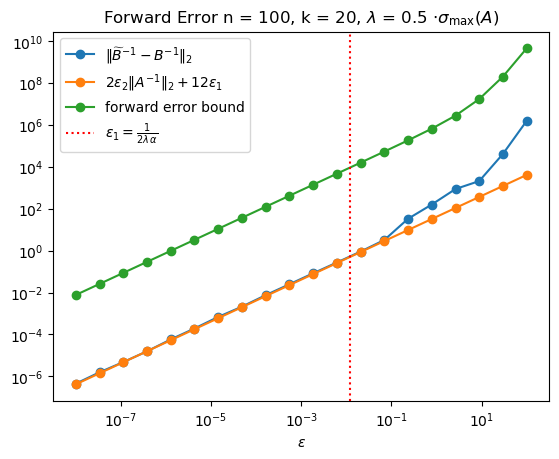

In [37]:
plt.loglog(es,errors,label=r'$\|\widetilde{B}^{-1}-B^{-1}\|_2$',marker='o')
plt.loglog(es,bounds,label=r'$2\epsilon_2 \|A^{-1}\|_2+ 12 \epsilon_1$ ',marker='o')
plt.loglog(es,full_bounds,label='forward error bound',marker='o')
plt.axvline(x=1/2/(lamda*alpha),ls=':',color='red',label=r'$\epsilon_1 = \frac{1}{2\lambda \,\alpha}$')
plt.legend()
plt.xlabel(r'$\epsilon$')
plt.title(f'Forward Error n = {n}, k = {k}, '+r'$\lambda$'+f' = {lamda_scale} '+(r'$\cdot\sigma_{\min}(A)$' if small_update else r'$\cdot\sigma_{\max}(A)$'))
plt.savefig('final_experiments/'+title_str+('_same_epsilon_small_update.png' if small_update else '_same_epsilon_large_update.png'))